## 反应直接预测结果分析
> 2024-11-04

### 1. 导入必要的包

In [1]:
import sys,os
sys.path.insert(0, os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(1,'../')
from config import conf as cfg
import pandas as pd
from tqdm import tqdm
import numpy as np
from tkinter import _flatten
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import plotly.graph_objects as go
from tools import btools
from IPython.display import HTML
from pandarallel import pandarallel # 导入pandaralle

pandarallel.initialize(progress_bar=False)
%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 112 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 2. 加载测试数据集

In [2]:
# 从 JSON 文件加载反应编码字典
with open(cfg.FILE_DS_DICT_RXN2ID, "r") as json_file:
    dict_rxn2id = json.load(json_file)
    print(f'加载反应编码字典完成，共有 {len(dict_rxn2id)} 个反应。')  # 打印加载的数据

# load datasets
ds_test = pd.read_feather(cfg.FILE_DS_TEST)[['uniprot_id', 
                                             'reaction_id', 
                                             'isenzyme',
                                             'ec_number',
                                             'ec_specific_level',
                                             'label'
                                             ]].rename(columns={'reaction_id':'rxn_groundtruth','isenzyme':'isenzyme_groundtruth','ec_number':'ec_groundtruth', 'label':'lb_rxn_groundtruth'})

print(f'测试集数据量: {len(ds_test)}')

methods = ['blast', 'deepec', 'clean', 'ecrecer', 'ecpred', 'catfam', 'priam']

print(f'使用预测方法{methods}')

ds_test.head(2)


加载反应编码字典完成，共有 10479 个反应。
测试集数据量: 13515
使用预测方法['blast', 'deepec', 'clean', 'ecrecer', 'ecpred', 'catfam', 'priam']


,uniprot_id,rxn_groundtruth,isenzyme_groundtruth,ec_groundtruth,ec_specific_level,lb_rxn_groundtruth
0,A9JLI2,-,False,-,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,A9JLI3,-,False,-,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 4. Load results from EC based method

In [3]:
# Read CSV files serially
def read_csv_files(file_paths):
    return [pd.read_csv(file, sep='\t') for file in file_paths]

# Function to get ec_rxn_nores
def get_ec_rxn_nores(pred_detail, eckey, rxnkey):
    no_prediction = len(pred_detail[(pred_detail[eckey].str.contains('NO-PREDICTION'))])
    ecwithout_reaction = len(pred_detail[(pred_detail[rxnkey].str.contains('EC-WITHOUT-REACTION'))])
    return [len(pred_detail), no_prediction, ecwithout_reaction]

def process_no_res(res_list, eckey, rxnkey):
    return pd.DataFrame([get_ec_rxn_nores(pred_detail=res_list[item], eckey=eckey, rxnkey=rxnkey) for item in range(10)], 
                        columns=['test_size', 'no_prediction', 'ec_without_rxn'])

# Make one-hot encoding label for each prediction
def make_labels(resdf, src_col1, src_col2, lb1, lb2, rxn_label_dict):
    resdf[[lb1, lb2]] = resdf.apply(
        lambda row: pd.Series({
            lb1: btools.make_label(reaction_id=str(row[src_col1]), rxn_label_dict=rxn_label_dict),
            lb2: btools.make_label(reaction_id=str(row[src_col2]), rxn_label_dict=rxn_label_dict)
        }), axis=1
    )
    return resdf

def apply_labels(res_list, src_col1, src_col2, lb1, lb2, rxn_label_dict):
    for i in tqdm(range(10)):
        res_list[i] = make_labels(resdf=res_list[i], src_col1=src_col1, src_col2=src_col2, lb1=lb1, lb2=lb2, rxn_label_dict=rxn_label_dict)
    return res_list

# Function to calculate metrics
def calculate_metrics(res_df_list, item, method):
    return btools.rxn_eva_metric(eva_df=res_df_list[item], eva_name=f'{method}_fold_{item+1}', methods=[method])

def process_metrics(res_list, method, max_workers=10):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(calculate_metrics, res_list, item, method) for item in range(10)]
        metrics = [future.result() for future in as_completed(futures)]
    metrics_df = pd.concat(metrics, axis=0).reset_index(drop=True)
    metrics_df['baselineName'] = metrics_df.apply(lambda x: f'fold_{x.name+1}', axis=1)
    return metrics_df

# Function to display results as HTML
def display_html_results(metrics, fold_std, eva_name):
    return HTML(f"""
         <div style="float:left; width:900px;">
              <h2 style='color:blue'>{eva_name} Evaluation 10 Fold Details</h2>
              {metrics.to_html()}
         </div>
         <div  style="float:left; width:400px;" >
              <h2 style='color:blue' >{eva_name} Evaluation 10 Fold Overview</h2>
                   {fold_std.to_html()}
         </div>
         """)

### 4.1 Blast

In [5]:
# Blast Results Processing
vali_res_blast = [f'{cfg.DIR_PROJECT_ROOT}/baselines/results/ec_methods/blast/fold{item}.tsv' for item in range(1, 11)]
res_blast = read_csv_files(vali_res_blast)
df_blast_no_pred = process_no_res(res_blast, eckey='ec_blast', rxnkey='rxn_ecblast')
res_blast = apply_labels(res_blast, 'reaction_groundtruth', 'rxn_ecblast', 'lb_rxn_groundtruth', 'lb_rxn_blast', dict_rxn2id)
res_blast_metrics = process_metrics(res_blast, 'blast')
res_blast_metrics = pd.concat([res_blast_metrics, df_blast_no_pred], axis=1)

#补充方法名称
res_blast_metrics['runFold'] = res_blast_metrics.baselineName
res_blast_metrics.baselineName = 'Blast_via_EC'
res_blast_metrics.to_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_blast_metrics.feather')


res_blast_fold_std = res_blast_metrics[['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'no_prediction', 'ec_without_rxn']].agg(['mean', 'std'])
display_html_results(res_blast_metrics, res_blast_fold_std, 'Blast')

100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


Evaluating: Reaction Predcition Results blast_fold_1
Evaluating: Reaction Predcition Results blast_fold_2
Evaluating: Reaction Predcition Results blast_fold_3
Evaluating: Reaction Predcition Results blast_fold_4
Evaluating: Reaction Predcition Results blast_fold_5
Evaluating: Reaction Predcition Results blast_fold_6
Evaluating: Reaction Predcition Results blast_fold_7
Evaluating: Reaction Predcition Results blast_fold_8
Evaluating: Reaction Predcition Results blast_fold_9
Evaluating: Reaction Predcition Results blast_fold_10


,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,Blast_via_EC,0.818219,0.904869,0.774860,0.784454,50858,2424,2588,fold_1
1,Blast_via_EC,0.818141,0.894471,0.773167,0.782766,50858,2386,2590,fold_2
2,Blast_via_EC,0.814365,0.907530,0.773451,0.783372,50858,2379,2751,fold_3
3,Blast_via_EC,0.815309,0.909223,0.770627,0.780678,50858,2301,2628,fold_4
4,Blast_via_EC,0.816646,0.908945,0.775516,0.785399,50858,2418,2591,fold_5
5,Blast_via_EC,0.817236,0.907138,0.775457,0.785389,50858,2391,2633,fold_6
6,Blast_via_EC,0.815113,0.903960,0.774638,0.785443,50858,2369,2615,fold_7
7,Blast_via_EC,0.812655,0.909814,0.770326,0.780436,50858,2381,2674,fold_8
8,Blast_via_EC,0.815034,0.899002,0.767950,0.777427,50858,2449,2626,fold_9
9,Blast_via_EC,0.816155,0.918055,0.772610,0.782583,50858,2431,2584,fold_10


### 4.2 DeepEC

In [11]:
# DeepEC Results Processing
vali_res_deepec_rxn = [f'{cfg.DIR_RES_BASELINE}results/ec_methods/deepec/fold_{item}.tsv' for item in range(1, 11)]
res_ec_deepec = read_csv_files(vali_res_deepec_rxn)
df_deepec_no_pred = process_no_res(res_ec_deepec, eckey='ec_deepec', rxnkey='reaction_deepec')
res_ec_deepec = apply_labels(res_ec_deepec, 'reaction_groundtruth', 'reaction_deepec', 'lb_rxn_groundtruth', 'lb_rxn_deepec', dict_rxn2id)
res_deepec_metrics = process_metrics(res_ec_deepec, 'deepec')
res_deepec_metrics = pd.concat([res_deepec_metrics, df_deepec_no_pred], axis=1)

#补充方法名称
res_deepec_metrics['runFold'] = res_deepec_metrics.baselineName
res_deepec_metrics.baselineName = 'DeepEC'
res_deepec_metrics.to_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_deepec_metrics.feather')

res_deepec_fold_std = res_deepec_metrics[['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'no_prediction', 'ec_without_rxn']].agg(['mean', 'std'])
display_html_results(res_deepec_metrics, res_deepec_fold_std, 'DeepEC')

100%|██████████| 10/10 [02:01<00:00, 12.14s/it]


Evaluating: Reaction Predcition Results deepec_fold_1Evaluating: Reaction Predcition Results deepec_fold_2

Evaluating: Reaction Predcition Results deepec_fold_3
Evaluating: Reaction Predcition Results deepec_fold_4
Evaluating: Reaction Predcition Results deepec_fold_5
Evaluating: Reaction Predcition Results deepec_fold_6
Evaluating: Reaction Predcition Results deepec_fold_7
Evaluating: Reaction Predcition Results deepec_fold_8
Evaluating: Reaction Predcition Results deepec_fold_9
Evaluating: Reaction Predcition Results deepec_fold_10


,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,DeepEC,0.293798,0.794857,0.313444,0.296721,50858,30918,1572,fold_1
1,DeepEC,0.295057,0.468772,0.312436,0.296577,50858,30958,1543,fold_2
2,DeepEC,0.296394,0.787416,0.314352,0.298151,50858,30749,1673,fold_3
3,DeepEC,0.292324,0.596970,0.311300,0.294721,50858,30916,1587,fold_4
4,DeepEC,0.291478,0.698312,0.312777,0.297000,50858,30799,1580,fold_5
5,DeepEC,0.292501,0.670122,0.310283,0.293809,50858,30908,1588,fold_6
6,DeepEC,0.295666,0.796326,0.314134,0.297887,50858,30984,1600,fold_7
7,DeepEC,0.294565,0.789211,0.314474,0.298498,50858,30991,1569,fold_8
8,DeepEC,0.293602,0.468735,0.312926,0.296822,50858,30938,1594,fold_9
9,DeepEC,0.294801,0.793383,0.314107,0.298265,50858,31044,1537,fold_10


### 4.3 CLEAN

In [12]:
# Clean Results Processing
vali_res_clean_rxn = [f'{cfg.DIR_RES_BASELINE}results/ec_methods/clean/fold_{item}.tsv' for item in range(1, 11)]
res_clean = read_csv_files(vali_res_clean_rxn)
df_clean_no_pred = process_no_res(res_clean, eckey='ec_clean', rxnkey='reaction_clean')
res_clean = apply_labels(res_clean, 'reaction_groundtruth', 'reaction_clean', 'lb_rxn_groundtruth', 'lb_rxn_clean', dict_rxn2id)
res_clean_metrics = process_metrics(res_clean, 'clean')
res_clean_metrics = pd.concat([res_clean_metrics, df_clean_no_pred], axis=1)

#补充方法名称
res_clean_metrics['runFold'] = res_clean_metrics.baselineName
res_clean_metrics.baselineName = 'CLEAN'
res_clean_metrics.to_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_clean_metrics.feather')


res_clean_fold_std = res_clean_metrics[['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'no_prediction', 'ec_without_rxn']].agg(['mean', 'std'])
display_html_results(res_clean_metrics, res_clean_fold_std, 'Clean')

100%|██████████| 10/10 [01:54<00:00, 11.48s/it]


Evaluating: Reaction Predcition Results clean_fold_1
Evaluating: Reaction Predcition Results clean_fold_2
Evaluating: Reaction Predcition Results clean_fold_3
Evaluating: Reaction Predcition Results clean_fold_4
Evaluating: Reaction Predcition Results clean_fold_5
Evaluating: Reaction Predcition Results clean_fold_6
Evaluating: Reaction Predcition Results clean_fold_7
Evaluating: Reaction Predcition Results clean_fold_8
Evaluating: Reaction Predcition Results clean_fold_9
Evaluating: Reaction Predcition Results clean_fold_10


,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,CLEAN,0.329132,0.820416,0.354308,0.302624,50858,0,8422,fold_1
1,CLEAN,0.327284,0.817173,0.351229,0.299286,50858,0,8454,fold_2
2,CLEAN,0.326930,0.823910,0.352811,0.300442,50858,0,8445,fold_3
3,CLEAN,0.330096,0.815567,0.354734,0.303291,50858,0,8359,fold_4
4,CLEAN,0.324531,0.823268,0.350537,0.299188,50858,0,8505,fold_5
5,CLEAN,0.326242,0.817681,0.351318,0.299232,50858,0,8526,fold_6
6,CLEAN,0.325200,0.823811,0.353383,0.302272,50858,0,8498,fold_7
7,CLEAN,0.330607,0.814915,0.355162,0.303243,50858,0,8381,fold_8
8,CLEAN,0.328385,0.661943,0.352310,0.300568,50858,0,8542,fold_9
9,CLEAN,0.328444,0.815624,0.352898,0.301182,50858,0,8550,fold_10


### 4.4 ECRECer

In [13]:
# ECRECer Results Processing
vali_res_ecrecer_rxn = [f'{cfg.DIR_RES_BASELINE}results/ec_methods/ecrecer/fold_{item}.tsv' for item in range(1, 11)]
res_ecrecer = read_csv_files(vali_res_ecrecer_rxn)
df_ecrecer_no_pred = process_no_res(res_ecrecer, eckey='ec_ecrecer', rxnkey='rxn_ecrecer')
res_ecrecer = apply_labels(res_ecrecer, 'reaction_groundtruth', 'rxn_ecrecer', 'lb_rxn_groundtruth', 'lb_rxn_ecrecer', dict_rxn2id)
res_ecrecer_metrics = process_metrics(res_ecrecer, 'ecrecer')
res_ecrecer_metrics = pd.concat([res_ecrecer_metrics, df_ecrecer_no_pred], axis=1)

#补充方法名称
res_ecrecer_metrics['runFold'] = res_ecrecer_metrics.baselineName
res_ecrecer_metrics.baselineName = 'ECRECer'
res_ecrecer_metrics.to_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_ecrecer_metrics.feather')

res_ecrecer_fold_std = res_ecrecer_metrics[['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'no_prediction', 'ec_without_rxn']].agg(['mean', 'std'])
display_html_results(res_ecrecer_metrics, res_ecrecer_fold_std, 'ECRECer')

100%|██████████| 10/10 [01:51<00:00, 11.18s/it]


Evaluating: Reaction Predcition Results ecrecer_fold_1
Evaluating: Reaction Predcition Results ecrecer_fold_2
Evaluating: Reaction Predcition Results ecrecer_fold_3
Evaluating: Reaction Predcition Results ecrecer_fold_4
Evaluating: Reaction Predcition Results ecrecer_fold_5
Evaluating: Reaction Predcition Results ecrecer_fold_6
Evaluating: Reaction Predcition Results ecrecer_fold_7
Evaluating: Reaction Predcition Results ecrecer_fold_8
Evaluating: Reaction Predcition Results ecrecer_fold_9
Evaluating: Reaction Predcition Results ecrecer_fold_10


,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,ECRECer,0.875044,0.950653,0.802625,0.806791,50858,0,2953,fold_1
1,ECRECer,0.873314,0.935831,0.794605,0.798072,50858,0,2993,fold_2
2,ECRECer,0.873373,0.939369,0.799853,0.803454,50858,0,3154,fold_3
3,ECRECer,0.870384,0.944382,0.795887,0.799832,50858,0,3074,fold_4
4,ECRECer,0.873176,0.936793,0.796044,0.800144,50858,0,3012,fold_5
5,ECRECer,0.872567,0.939177,0.796762,0.800743,50858,0,3042,fold_6
6,ECRECer,0.876873,0.949961,0.801769,0.805219,50858,0,2993,fold_7
7,ECRECer,0.872960,0.941878,0.799392,0.803242,50858,0,3059,fold_8
8,ECRECer,0.874926,0.943126,0.801762,0.805310,50858,0,3066,fold_9
9,ECRECer,0.872606,0.946377,0.797657,0.801316,50858,0,3061,fold_10


### 4.5 CATFAM

In [ ]:
# CATFAM Results Processing
vali_res_catfam_rxn = [f'{cfg.DIR_RES_BASELINE}results/ec_methods/catfam/fold_{item}.tsv' for item in range(1, 11)]
res_catfam = read_csv_files(vali_res_catfam_rxn)
df_catfam_no_pred = process_no_res(res_catfam, eckey='ec_catfam', rxnkey='rxn_catfam')
res_catfam = apply_labels(res_catfam, 'reaction_groundtruth', 'rxn_catfam', 'lb_rxn_groundtruth', 'lb_rxn_catfam', dict_rxn2id)
res_catfam_metrics = process_metrics(res_catfam, 'catfam')
res_catfam_metrics = pd.concat([res_catfam_metrics, df_catfam_no_pred], axis=1)

#补充方法名称
res_catfam_metrics['runFold'] = res_catfam_metrics.baselineName
res_catfam_metrics.baselineName = 'CatFam'
res_catfam_metrics.to_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_catfam_metrics.feather')

res_catfam_fold_std = res_catfam_metrics[['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'no_prediction', 'ec_without_rxn']].agg(['mean', 'std'])
display_html_results(res_catfam_metrics, res_catfam_fold_std, 'CATFAM')
display_html_results(res_catfam_metrics, res_catfam_fold_std, 'CATFAM')

,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,CatFam,0.770675,0.850983,0.712115,0.668797,50858,0,2109,fold_1
1,CatFam,0.770380,0.844415,0.714195,0.669735,50858,0,2149,fold_2
2,CatFam,0.772523,0.853241,0.715021,0.672002,50858,0,2221,fold_3
3,CatFam,0.771442,0.839872,0.715581,0.671479,50858,0,2233,fold_4
4,CatFam,0.769338,0.841067,0.709931,0.666423,50858,0,2214,fold_5
5,CatFam,0.771737,0.859790,0.713994,0.670974,50858,0,2158,fold_6
6,CatFam,0.769535,0.854616,0.708613,0.665166,50858,0,2213,fold_7
7,CatFam,0.772130,0.845439,0.715684,0.673031,50858,0,2198,fold_8
8,CatFam,0.772445,0.853308,0.718281,0.674618,50858,0,2123,fold_9
9,CatFam,0.766290,0.852771,0.709331,0.665500,50858,0,2104,fold_10


### 4.6 PRIAM

In [15]:
# PRIAM Results Processing
vali_res_priam_rxn = [f'{cfg.DIR_RES_BASELINE}results/ec_methods/priam/fold_{item}.tsv' for item in range(1, 11)]
res_priam = read_csv_files(vali_res_priam_rxn)
df_priam_no_pred = process_no_res(res_priam, eckey='ec_priam', rxnkey='rxn_priam')
res_priam = apply_labels(res_priam, 'reaction_groundtruth', 'rxn_priam', 'lb_rxn_groundtruth', 'lb_rxn_priam', dict_rxn2id)
res_priam_metrics = process_metrics(res_priam, 'priam')
res_priam_metrics = pd.concat([res_priam_metrics, df_priam_no_pred], axis=1)

#补充方法名称
res_priam_metrics['runFold'] = res_priam_metrics.baselineName
res_priam_metrics.baselineName = 'PRIAM'
res_priam_metrics.to_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_priam_metrics.feather')


res_priam_fold_std = res_priam_metrics[['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'no_prediction', 'ec_without_rxn']].agg(['mean', 'std'])


display_html_results(res_priam_metrics, res_priam_fold_std, 'PRIAM')

100%|██████████| 10/10 [01:55<00:00, 11.57s/it]


Evaluating: Reaction Predcition Results priam_fold_1Evaluating: Reaction Predcition Results priam_fold_2

Evaluating: Reaction Predcition Results priam_fold_3
Evaluating: Reaction Predcition Results priam_fold_4
Evaluating: Reaction Predcition Results priam_fold_5
Evaluating: Reaction Predcition Results priam_fold_6
Evaluating: Reaction Predcition Results priam_fold_7
Evaluating: Reaction Predcition Results priam_fold_8
Evaluating: Reaction Predcition Results priam_fold_9
Evaluating: Reaction Predcition Results priam_fold_10


,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,PRIAM,0.085611,0.680622,0.379586,0.224087,50858,14343,2625,fold_1
1,PRIAM,0.085867,0.520728,0.384268,0.226977,50858,14432,2725,fold_2
2,PRIAM,0.086594,0.680500,0.379973,0.222292,50858,14313,2782,fold_3
3,PRIAM,0.087263,0.528602,0.383063,0.226419,50858,14233,2876,fold_4
4,PRIAM,0.085965,0.683731,0.382887,0.225909,50858,14307,2699,fold_5
5,PRIAM,0.085709,0.686245,0.378193,0.222428,50858,14358,2746,fold_6
6,PRIAM,0.087715,0.683375,0.382141,0.227754,50858,14319,2722,fold_7
7,PRIAM,0.085985,0.682326,0.381596,0.224561,50858,14326,2794,fold_8
8,PRIAM,0.086515,0.694737,0.382978,0.224811,50858,14409,2745,fold_9
9,PRIAM,0.087105,0.685258,0.382271,0.227135,50858,14627,2658,fold_10


## 5.Evaluation Results

In [263]:
res_blast_metrics = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_blast_metrics.feather')
res_deepec_metrics = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_deepec_metrics.feather')
res_clean_metrics = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_clean_metrics.feather')
res_ecrecer_metrics = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_ecrecer_metrics.feather')
res_catfam_metrics  = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_catfam_metrics.feather')
res_priam_metrics = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/evaluation/data/res_priam_metrics.feather')
res_metrics = pd.concat([res_blast_metrics,res_deepec_metrics, res_clean_metrics, res_ecrecer_metrics, res_catfam_metrics, res_priam_metrics], axis=0).reset_index(drop=True)
res_metrics.head(3)

,baselineName,mAccuracy,mPrecision,mRecall,mF1,test_size,no_prediction,ec_without_rxn,runFold
0,Blast_via_EC,0.818219,0.904869,0.774860,0.784454,50858,2424,2588,fold_1
1,Blast_via_EC,0.818141,0.894471,0.773167,0.782766,50858,2386,2590,fold_2
2,Blast_via_EC,0.814365,0.907530,0.773451,0.783372,50858,2379,2751,fold_3


In [361]:
def get_fold_mean_std_metrics(input_df):
    # 对数值列进行分组聚合
    res_fold_std = input_df[['baselineName', 'mAccuracy', 'mPrecision', 'mRecall', 'mF1']]
    # 对每个 baselineName 进行分组并计算均值和标准差
    res_fold_std = res_fold_std.groupby('baselineName').agg(['mean', 'std'])
    # 重置索引以简化处理
    res_fold_std = res_fold_std.reset_index()
    # 修改列名，将 MultiIndex 转换为单层列名
    res_fold_std.columns = ['_'.join(filter(None, col)).strip() for col in res_fold_std.columns]
    # 使用 melt 方法将列转换为行
    res_fold_std_melted = res_fold_std.melt(id_vars=['baselineName'], var_name='Metric_Statistic', value_name='Value')
    # 将 'Metric_Statistic' 列分割成 'Metric' 和 'Statistic'
    res_fold_std_melted[['Metric', 'Statistic']] = res_fold_std_melted['Metric_Statistic'].str.rsplit('_', n=1, expand=True)
    # 删除原来的 'Metric_Statistic' 列
    res_fold_std_melted = res_fold_std_melted.drop(columns=['Metric_Statistic'])
    # 使用 pivot 将数据转换为所需格式
    res_fold_std_pivot = res_fold_std_melted.pivot_table(index=['baselineName', 'Metric'], columns='Statistic', values='Value').reset_index()
    # 重命名列
    res_fold_std_pivot.columns.name = None
    res_fold_std_pivot.columns = ['Method', 'Metric', 'Mean', 'Std']
    return res_fold_std_pivot

res_fold_std = get_fold_mean_std_metrics(input_df=res_metrics)
res_fold_std

,Method,Metric,Mean,Std
0,Blast_via_EC,mAccuracy,0.815887,0.001745
1,Blast_via_EC,mF1,0.782795,0.002636
2,Blast_via_EC,mPrecision,0.906301,0.006403
3,Blast_via_EC,mRecall,0.772860,0.002516
4,CLEAN,mAccuracy,0.327685,0.002012
5,CLEAN,mF1,0.301133,0.001641
6,CLEAN,mPrecision,0.803431,0.049839
7,CLEAN,mRecall,0.352869,0.001561
8,CatFam,mAccuracy,0.770650,0.001908
9,CatFam,mF1,0.669772,0.003250


In [313]:
# 确保 res_fold_std 按照 F1 值排序，但保留所有度量以便绘图
methods_order = res_fold_std[res_fold_std['Metric'] == 'F1'].sort_values(by='Mean')['Method'].unique()
# methods = res_fold_std['Method'].unique()
methods 

array(['Blast_via_EC', 'CLEAN', 'CatFam', 'DeepEC', 'ECRECer', 'PRIAM'],
      dtype=object)

In [323]:
res_fold_std[res_fold_std.Metric=='mF1'].sort_values(by=['Mean']).Method.tolist()

['PRIAM', 'DeepEC', 'CLEAN', 'CatFam', 'Blast_via_EC', 'ECRECer']

In [439]:
# 定义颜色
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2', '#999999']

# 确保 res_fold_std 按照 F1 值排序，但保留所有度量以便绘图
# 获取唯一的方法名称
methods = res_fold_std[res_fold_std.Metric == 'mF1'].sort_values(by=['Mean']).Method.tolist()

# 创建一个绘图对象
fig = go.Figure()

# 为每个方法添加柱状图，并使用指定颜色
for idx, method in enumerate(methods):
    df_method = res_fold_std[res_fold_std['Method'] == method]
    # 只在 df_method 非空的情况下添加 trace
    if not df_method.empty:
        fig.add_trace(
            go.Bar(
                name=method,
                x=df_method['Metric'],
                y=df_method['Mean'],
                width=0.11,  # 调整柱状图的宽度
                error_y=dict(
                    type='data',
                    array=df_method['Std'],
                    visible=True
                ),
                marker_color=colors[idx % len(colors)],  # 使用指定的颜色循环
                marker_line=dict(color='black', width=0.5)  # 添加黑色1px外边框
            )
        )

# 更新布局
fig.update_layout(
    yaxis=dict(
        showline=True, linecolor='black', linewidth=1,
        showgrid=True, gridcolor='gray', gridwidth=1,
        minor=dict(
            showgrid=True,
            griddash='dash',  # 设置网格线为虚线
            gridcolor='gray',
            gridwidth=0.5,
            dtick=0.05
        ),
        dtick=0.1,  # 每隔 0.1 的主要网格线
        range=[0, 1.1]  # y 轴的刻度最大值调整为 1.2
    ),
    xaxis=dict(showline=True,linecolor='#000000',linewidth=1),       
    title=dict(
    text='Performance Comparison of EC-based Reaction Prediction Methods',
    x=0.5,
    y=0.05,
    xanchor='center',
    font=dict(
        size=20,
        weight=1000
    )
    ),
    # xaxis_title='Metric',
    yaxis_title='Mean Value',
    width=1600,
    height=600,
    barmode='group',
    bargap=0.29,  # 设置柱状图之间的间距
    template='plotly_white',
    legend=dict(
        orientation="h",  # 水平放置图例
        yanchor="bottom",
        y=0.99,  # 将图例放置在下方
        xanchor="center",
        x=0.5,
        tracegroupgap=2,  # 图例列数
        borderwidth=1,  # 添加黑色1px外边框
    ),

)

# 显示图形
fig.show()


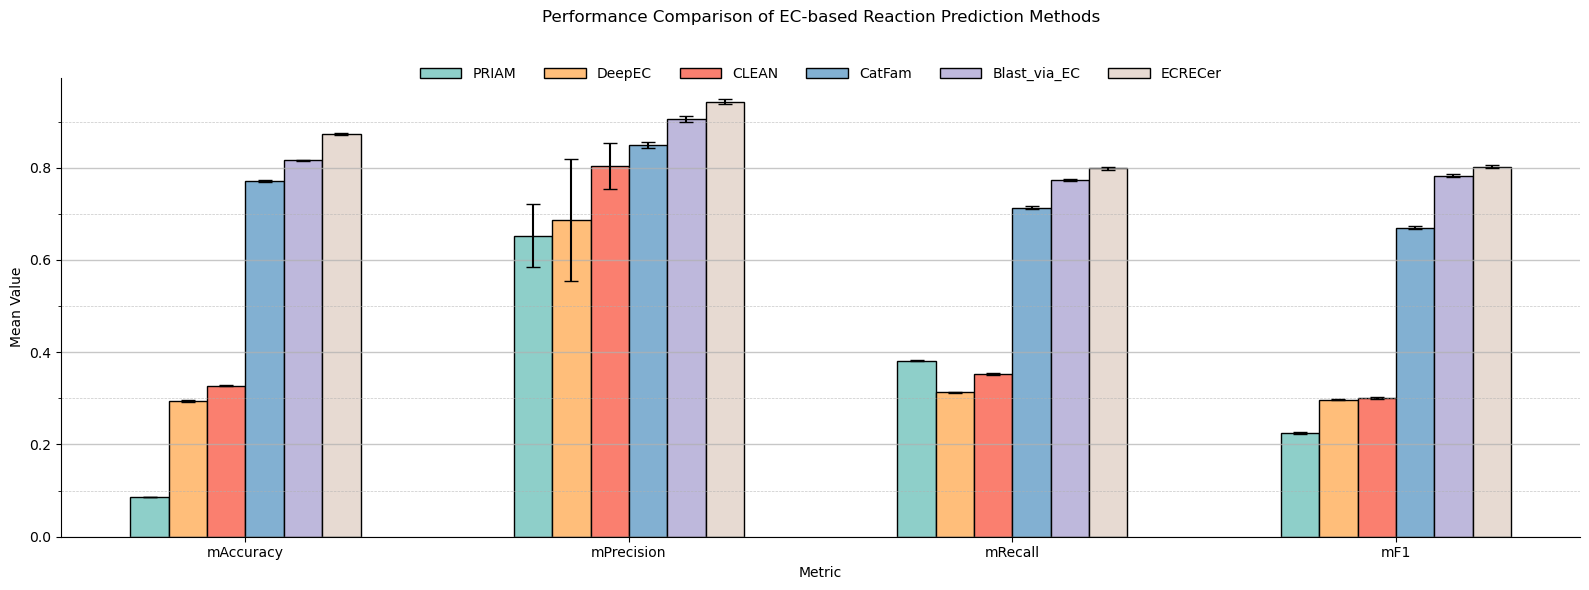

In [364]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for each baselineName and metric
metrics = ['mAccuracy', 'mPrecision', 'mRecall', 'mF1']
res_summary = res_metrics.groupby('baselineName')[metrics].agg(['mean', 'std']).reset_index()
res_summary.columns = ['baselineName'] + [f'{metric}_{stat}' for metric in metrics for stat in ['mean', 'std']]

# Sort baselineNames by mF1 mean value in ascending order
res_summary = res_summary.sort_values(by='mF1_mean')
baseline_names = res_summary['baselineName'].unique()

# Define colors for each baselineName
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2', '#999999']  # Updated color set to match the scientific publication style
color_map = {name: colors[i % len(colors)] for i, name in enumerate(baseline_names)}

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(metrics))  # The label locations
width = 0.1  # Width of the bars

# Loop through each baselineName and plot bars for each metric
for i, baseline_name in enumerate(baseline_names):
    means = [res_summary.loc[res_summary['baselineName'] == baseline_name, f'{metric}_mean'].values[0] for metric in metrics]
    stds = [res_summary.loc[res_summary['baselineName'] == baseline_name, f'{metric}_std'].values[0] for metric in metrics]
    ax.bar(x + i * width, means, width, yerr=stds, label=baseline_name, color=color_map[baseline_name], capsize=5, edgecolor='black')

# Customize the plot
ax.set_title('Performance Comparison of EC-based Reaction Prediction Methods', pad=40)
ax.set_xlabel('Metric')
ax.set_ylabel('Mean Value')
ax.set_xticks(x + width * (len(baseline_names) / 2 - 0.5))
ax.set_xticklabels(metrics)
ax.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, frameon=False, handlelength=3)  # Move legend below the plot

# Add primary and secondary horizontal grid lines
ax.set_yticks(np.arange(0, ax.get_ylim()[1], 0.1))
ax.grid(axis='y', which='both', linestyle='--', alpha=0.7)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=1.0)
ax.yaxis.grid(True, which='minor', linestyle='--', linewidth=0.5)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase space between groups by adjusting width and offsets
plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.2, wspace=1.5)

# Show the figure
plt.tight_layout()
plt.show()




### 5.1 isEnzyme prediction

In [16]:
print('isEnzyme Predcition Results - EC METHODs')
method = ['ecblast', 'deepec', 'clean', 'ecrecer', 'ecpred', 'catfam', 'priam']
resl = []
for m in method:
    res_item = btools.eva_isenzyme(baselineName=m, res_df=res_method_ec, category='ec')
    resl.append(res_item)
    
resl=pd.DataFrame(resl, columns=['baselineName', 'Accuracy', 'Precision', 'Recall', 'PPV(Sensitivity)', 'NPV(Specificity)', 'F1', 'TP', 'FP', 'FN', 'TN', 'UP', 'UN'])

resl.sort_values(by=['F1'], ascending=False).reset_index(drop=True)

isEnzyme Predcition Results - EC METHODs


,baselineName,Accuracy,Precision,Recall,PPV(Sensitivity),NPV(Specificity),F1,TP,FP,FN,TN,UP,UN
0,ecrecer,0.789493,0.532835,0.911388,0.532835,0.964646,0.672499,2921,2561,284,7749,0,0
1,ecpred,0.597839,0.346035,0.631643,0.346035,0.703467,0.447122,2579,3930,560,5499,65,879
2,catfam,0.810285,0.749416,0.300468,0.749416,0.816680,0.428953,963,322,2242,9988,0,0
3,clean,0.237144,0.237144,1.000000,0.237144,0.000000,0.383373,3205,10310,0,0,0,0
4,ecblast,0.547244,0.302502,0.343502,0.302502,0.370370,0.321701,2466,1406,433,4930,306,3974
5,priam,0.218498,0.218498,0.397069,0.218498,0.000000,0.281882,2953,6078,0,0,252,4232
6,deepec,0.090196,0.090196,0.093446,0.090196,0.000000,0.091792,1219,470,0,0,1986,9840


In [74]:
fig_data = resl.sort_values(by=['F1']).set_index('baselineName').T.head(6)


plotdata = []
for method in fig_data.columns.values:
    plotdata.append(go.Bar(
        x=fig_data.index, 
        y=fig_data[f'{method}'], 
        name=f'{method}',
        text=fig_data[f'{method}'],
        textposition='auto',
        texttemplate='%{text:.2f}',  # 格式化数值标签 (保留两位小数)
        ))

fig = go.Figure(
    data=plotdata,
    layout=dict(
        barcornerradius=10,
        
    ),
)

fig.show()

### 5.2 Reaction prediction

In [6]:
# Make Label
res_method_ec['lb_rxn_blast'] = res_method_ec.reaction_ecblast.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))
res_method_ec['lb_rxn_deepec'] = res_method_ec.reaction_deepec.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))
res_method_ec['lb_rxn_clean'] = res_method_ec.reaction_clean.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))
res_method_ec['lb_rxn_ecrecer'] = res_method_ec.reaction_ecrecer.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))
res_method_ec['lb_rxn_ecpred'] = res_method_ec.reaction_ecpred.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))
res_method_ec['lb_rxn_catfam'] = res_method_ec.reaction_catfam.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))
res_method_ec['lb_rxn_priam'] = res_method_ec.reaction_priam.apply(lambda x: btools.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id))

#full
metrics_rxn_fullset = btools.rxn_eva_metric(eva_df=res_method_ec, eva_name='[FULL SET]', methods=methods)
#noneenzyme
res_noneenzyme = res_method_ec[res_method_ec.rxn_groundtruth=='-'].reset_index(drop=True)
metrics_rxn_noneenzyme = btools.rxn_eva_metric(eva_df=res_noneenzyme, eva_name='[NONE ENZYME]', methods=methods)
#enzyme
res_enzyme = res_method_ec[res_method_ec.rxn_groundtruth!='-'].reset_index(drop=True)
metrics_rxn_enzyme = btools.rxn_eva_metric(eva_df=res_enzyme, eva_name='[ENZYME]', methods=methods)

Evaluating: Reaction Predcition Results [FULL SET]
Evaluating: Reaction Predcition Results [NONE ENZYME]
Evaluating: Reaction Predcition Results [ENZYME]


In [11]:
#show results
HTML(f'''
     <div style="float:left; width: 25%;"><h2>Reaction Predcition Results <span style="color:red"> [FULL SET]</span></h2>{metrics_rxn_fullset.sort_values(by=['mF1'], ascending=False).reset_index(drop=True).to_html()} </div>
     <div style="float:left; width: 25%;"><h2>Reaction Predcition Results <span style="color:red"> [NONE-ENZYME]</span></h2>{metrics_rxn_noneenzyme.sort_values(by=['mF1'], ascending=False).reset_index(drop=True).to_html()} </div>
     <div style="float:left; width: 25%;"><h2>Reaction Predcition Results <span style="color:red"> [ENZYME]</span></h2>{metrics_rxn_enzyme.sort_values(by=['mF1'], ascending=False).reset_index(drop=True).to_html()} </div>
     ''')

,baselineName,mAccuracy,mPrecision,mRecall,mF1
0,ecrecer,0.689900,0.967961,0.651723,0.714824
1,catfam,0.770477,0.870005,0.670351,0.620349
2,blast,0.433370,0.907868,0.409190,0.504355
3,ecpred,0.420792,0.926196,0.363490,0.455263
4,clean,0.078949,0.879031,0.145483,0.097747
5,priam,0.017832,0.853372,0.160137,0.075407
6,deepec,0.034850,0.978400,0.052406,0.059727
,baselineName,mAccuracy,mPrecision,mRecall,mF1
0,catfam,0.968768,1.0,0.968768,0.984136
1,ecrecer,0.751600,1.0,0.751600,0.858187
